** Libraries import **

In [1]:
!pip install SimpleITK-SimpleElastix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 18.6 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
import numpy as np                                            
import matplotlib.pyplot as plt                 
from sklearn.cluster import KMeans
from skimage import measure, morphology, segmentation 
import SimpleITK as sitk
import nibabel as nib
import scipy.ndimage
from scipy import ndimage as ndi
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing, opening
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
import skimage.morphology
from skimage.morphology import closing, square,cube, dilation, ball
from skimage import measure, feature
from skimage.segmentation import clear_border, mark_boundaries
import os
from google.colab import drive
import math
from sklearn.preprocessing import MinMaxScaler

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#Working directories
input_directory= '/content/gdrive/MyDrive/Colab Notebooks/Final Project MIRA/'
train_directory = input_directory+'train' 
test_directory = input_directory+'test'
parameters_directory= input_directory+'parameters'


In [5]:
def slice_show(image, slice_no, title,nibabel):
    """
    Function to visualize a 2D slice from the 3D image. 

    Args: 
    image (nifti, sitk.Image): Image that needs to be visualized.
    slice_no (int): Slice Number from 1 to 48.
    title (str): Title of the Image.
    nibabel => Boolean variable to know whether the image was loaded with nibabel or simpleITK library.
    
    Returns:
    (plt) Plot Image.

    """ 
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.title(title)
    if nibabel==True:
        plt.imshow(image[:,:,slice_no].T, cmap='gray') # Transpose the slice image from the one read by Nibabel as we want to see vertical image
    else:
        plt.imshow(image[:,:,slice_no], cmap='gray') # Transpose the slice image from the one read by Nibabel as we want to see vertical image
    #plt.imshow(image[:,:,slice_no].T, cmap='gray') # Transpose the slice image from the one read by Nibabel as we want to see vertical image

In [6]:
def computeTRE(transformed, target, voxel_size):
  """
  Function to compute the TRE between the transformed and target landmarks. 
  
  Args: 
  transformed (list): contains the transformed landmarks coordinates in x,y and z dimension.
  target (list): contains the landmarks coordinates of target image in x,y and z dimension.
  voxel_size (list): voxel spacing in x,y and z dimension.
  
  Returns: 
  tre_error (float) returns the TRE error per each pair of the landmark point.

  """ 

  #Computation of the TRE for each image coordinate
  x_diff_sqr =  pow(((transformed[0] - target[0])*voxel_size[0]),2)
  y_diff_sqr =  pow(((transformed[1] - target[1])*voxel_size[1]),2)
  z_diff_sqr =  pow(((transformed[2] - target[2])*voxel_size[2]),2)

  tre_error = math.sqrt(x_diff_sqr + y_diff_sqr + z_diff_sqr) # 3D Eucledian Distance Computation

  return tre_error

In [7]:
def computeTRE_MeanStd(transformed_landmarks, target_landmarks, voxel_size):
  """
  Function to compute the mean of the TRE and Standard deviation for 
  
  Inputs: 
  transformed_landmarks (list): a list of the transformed landmark points.
  target_landmarks (list): a list of the target image landmark points.
  voxel_size (list): voxel spacing in x,y and z dimension.
  
  output: returns the mean and std of TRE error per pair of the given two images.

  """ 
  all_tre = [] # A list which will hold all the TRE per point

  #Computation of the mean and standard deviation of the TRE 
  for i in range(len(transformed_landmarks)):
    temp_tre = computeTRE(transformed_landmarks[i], target_landmarks[i], voxel_size)
    all_tre.append(temp_tre)
  mean_tre = np.mean(all_tre) # Mean
  std_tre = np.std(all_tre) # Standard deviation
  return mean_tre, std_tre

In [8]:
def loadData(directory):
  """
  Function to load the data from a given directory in order to get it ready to work.

  Args:
  directory  (str): he place where train/validation/test images and landmarks are stored,

  Returns:
  inhale_images (list): list of the inhale images of all the patient.
  exhale_images (list): list of the exhale images of all the patient.
  inhale_images_metadata (sitk.Image): SimpleITK object of the inhale image. 
  exhale_images_metadata (sitk.Image): SimpleITK object of the exhale image.
  inhale_landmarks (list): list of the inhale image landmarks of all the patients.
  exhale_landmarks (list): list of the exhale image landmarks of all the patients.
  voxel_size_list (list): list of the voxel dimensions of the images of all the patient.

  """
  inhale_images = []
  exhale_images = []
  inhale_images_metadata = []
  exhale_images_metadata = []
  inhale_landmarks = []
  exhale_landmarks = []
  voxel_size_list = []


  for folders in sorted(os.listdir(directory)):
    images_directory = os.path.join(directory, folders) # Accessing each patient folder
    for files in sorted(os.listdir(images_directory)):
      if '.txt' in files: # Accessing each landmark files
        if '_eBH' in files: # Accessing each exhale landmark files
          with open(os.path.join(images_directory, files)) as f:
            exhale_landmarks_raw = []
            for line in f:
              exhale_landmarks_raw.append([float(n) for n in line.strip().split('\t')]) # Converting the text file to a list of points
            exhale_landmarks.append(exhale_landmarks_raw)
        elif '_iBH' in files: # Accessing each inhale landmark files
          with open(os.path.join(images_directory, files)) as f:
            inhale_landmarks_raw = []
            for line in f.readlines()[2:]:
              inhale_landmarks_raw.append([float(n) for n in line.strip().split('\t')]) # Converting the text file to a list of points
            inhale_landmarks.append(inhale_landmarks_raw)
        else:
          pass 
      else:
        if '_eBH' in files: # Accessing each exhale image files
          exhale_img_data= sitk.ReadImage(os.path.join(images_directory,files))
          exhale_images_metadata.append(exhale_img_data)
          sx,sy,sz= exhale_img_data.GetSpacing()
          voxel_size = [sx, sy, sz]
          voxel_size_list.append(voxel_size)
          exhale_img = np.moveaxis(sitk.GetArrayFromImage(exhale_img_data),0,-1)
          exhale_images.append(exhale_img)
        elif '_iBH' in files: # Accessing each inhale image files
          inhale_img_data = sitk.ReadImage(os.path.join(images_directory, files)) # reading the .nii image
          inhale_images_metadata.append(inhale_img_data)
          inhale_img = np.moveaxis(sitk.GetArrayFromImage(inhale_img_data),0,-1) 
          inhale_images.append(inhale_img)
        else: 
          pass
  return inhale_images, exhale_images, inhale_images_metadata, exhale_images_metadata, inhale_landmarks,exhale_landmarks, voxel_size_list

In [9]:
def preprocessImages(inhale_images, exhale_images,inhale_images_metadata, exhale_images_metadata):
    """
        Function to preprocess the raw images. 

        Args: 
        inhale_images (np.ndarray): 3D numpy array corresponding to the inhale image
        exhale_images (np.ndarray): 3D numpy array corresponding to the exhale image
        inhale_images_metadata (sitk.Image): SimpleITK image object corresponding to the inhale image
        exhale_images_metadata (sitk.Image): SimpleITK image object corresponding to the exhale image

        Returns: 
        preprocess_inhale (np.ndarray): 3D numpy array corresponding to the inhale image after preprocessing
        preprocess_exhale (np.ndarray): 3D numpy array corresponding to the exhale image after preprocessing
        preprocess_inhale_metadata (sitk.Image): SimpleITK image object corresponding to the inhale image after preprocessing
        preprocess_exhale_metadata (sitk.Image): SimpleITK image object corresponding to the exhale image after preprocessing

    """
    preprocess_inhale=[]
    preprocess_exhale=[]
    preprocess_inhale_metadata=[]
    preprocessed_exhale_metadata=[]

    for i in range(len(inhale_images)):
        preprocess_directory= train_directory+'/'+str(i+1)+"/"

        #Copy of input images
        inhale_images_array= inhale_images[i].copy()
        exhale_images_array= exhale_images[i].copy()

        #Setting to 0 pixels with value -2000
        inhale_images_array[inhale_images_array<0]=0
        exhale_images_array[exhale_images_array<0]=0
        
        #Obtaining min and max of both inhale and exhale images
        min_inhale= inhale_images_array.min()
        max_inhale= inhale_images_array.max()
        min_exhale= exhale_images_array.min()
        max_exhale= exhale_images_array.max()
        
        #Min-max normalization of both inhale and exhale images
        inhale_normalized= (inhale_images_array-min_inhale)/(max_inhale-min_inhale)
        exhale_normalized= (exhale_images_array-min_exhale)/(max_exhale-min_exhale)
        inhale_normalized *= 65535
        exhale_normalized *= 65535

        #Converting 3D numpy array to SimpleITK image object 
        inhale_preprocess_img = sitk.GetImageFromArray(np.moveaxis(inhale_normalized,-1,0))
        inhale_preprocess_img.CopyInformation(inhale_images_metadata[i])

        exhale_preprocess_img = sitk.GetImageFromArray(np.moveaxis(exhale_normalized,-1,0))
        exhale_preprocess_img.CopyInformation(exhale_images_metadata[i]) 

        #Exporting the image
        sitk.WriteImage(inhale_preprocess_img, preprocess_directory+"inhale_preprocessed"+str(i+1)+".nii.gz")
        sitk.WriteImage(exhale_preprocess_img, preprocess_directory+"exhale_preprocessed"+str(i+1)+".nii.gz")
        
        #Saving the results in the corresponding lists
        preprocess_inhale.append(inhale_normalized)
        preprocess_exhale.append(exhale_normalized)
        preprocess_inhale_metadata.append(inhale_preprocess_img)
        preprocessed_exhale_metadata.append(exhale_preprocess_img)

    return preprocess_inhale, preprocess_exhale, preprocess_inhale_metadata, preprocessed_exhale_metadata
    

In [10]:
def ConvertToHU(source_img):
    """
        Function to convert image to HU units.
        
        Args: 
        source_img (sitk.Image): source image in SimpleITK format. 

        Returns: 
        hu_img_array (np.ndarray): 3D numpy array with the image converted to HU units. 

    """
    
    #Rescaling the intensity of the image
    hu_img= sitk.RescaleIntensity(source_img,-1000,1000)
    hu_img_array= np.moveaxis(sitk.GetArrayFromImage(hu_img),0,-1)

    return hu_img_array

In [11]:
def ConvertToHuNibabel(source_img,patient,inhale):
      """
        Function to convert Nibabel image to HU units.
        
        Args: 
        source_img (Nibabel image): source image in SimpleITK format.
        patient (int): patient number. 
        inhale (bool):

        Returns: 
        img (Nibabel image): image converted to HU units.

      """
      #Loading the image
      img= nib.load(source_img)
      #Setting slope and intercept of the image
      arr_header= img.header
      arr_header.set_slope_inter(1,-1024)
      #Converting inhale and exhale images depending on the value of inhale variable 
      if inhale == True:
          nib.save(img, train_directory+'/'+str(patient+1)+'/HU_inhale_preprocessed_'+str(patient+1)+'.nii.gz')
      elif inhale== False:
          nib.save(img, train_directory+'/'+str(patient+1)+'/HU_exhale_preprocessed_'+str(patient+1)+'.nii.gz')
      else:
          pass

In [12]:
# Training Images and Landmarks
train_inhale_images,train_exhale_images,train_inhale_images_metadata,train_exhale_images_metadata,train_inhale_landmarks,train_exhale_landmarks, patient_voxel_size_list = loadData(train_directory)

In [13]:
# Preprocessed images
preprocessed_inhale, preprocessed_exhale, preprocessed_inhale_metadata, preprocessed_exhale_metadata = preprocessImages(train_inhale_images, train_exhale_images,train_inhale_images_metadata, train_exhale_images_metadata)

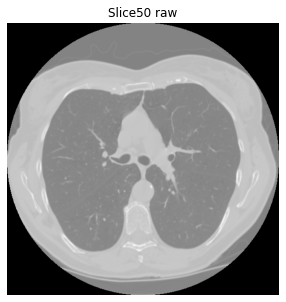

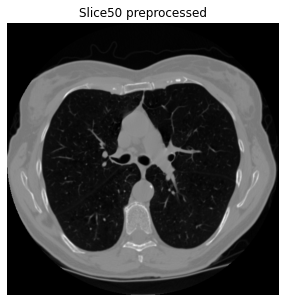

In [14]:
# Examples of image before and after preprocessing
slice_show(train_inhale_images[0],50,'Slice50 raw',False)
slice_show(preprocessed_inhale[0],50,'Slice50 preprocessed',False)

In [15]:
a= np.array(train_inhale_landmarks[0])

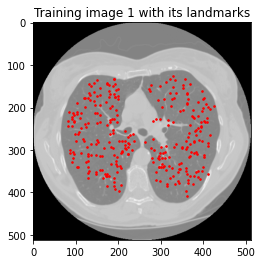

In [16]:
fig,ax = plt.subplots()
ax.imshow(train_inhale_images[0][:,:,50],cmap='gray')
ax.title.set_text('Training image 1 with its landmarks')
ax.scatter(a[:,0],a[:,1], s=10, marker='.', c='r')

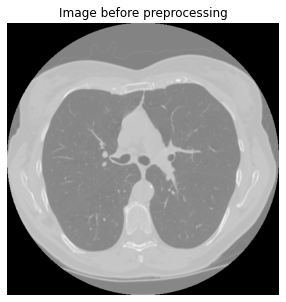

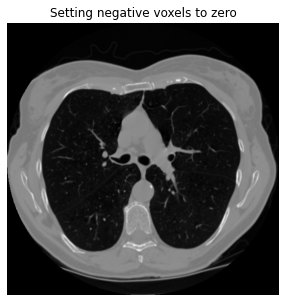

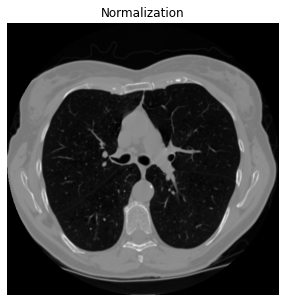

In [17]:
#Preprocessing steps for image 0
image_test= train_inhale_images[0].copy()
slice_show(image_test, 50, 'Image before preprocessing', False)
image_test[image_test<0]=0
slice_show(image_test,50,'Setting negative voxels to zero', False)
min_inhale= image_test.min()
max_inhale= image_test.max()
min_exhale= image_test.min()
max_exhale= image_test.max()
        
#Min-max normalization of both inhale and exhale images
inhale_normalized= (image_test-min_inhale)/(max_inhale-min_inhale)
inhale_normalized *= 65535

slice_show(inhale_normalized,50, 'Normalization', False)


In [18]:
#Converting exhale images to HU units
HU_images_sitk_inhale=[]
for i in range(4):
    HU_images_sitk_inhale.append(ConvertToHU(preprocessed_inhale_metadata[i]))

In [19]:
#Converting exhale images to HU units
HU_images_sitk_exhale=[]
for i in range(4):
    HU_images_sitk_exhale.append(ConvertToHU(preprocessed_exhale_metadata[i]))

In [20]:
#Saving the inhale images after converted to HU units
HU_images_nibabel_inhale=[]
for i in range(4):
    img= nib.load(train_directory+'/'+str(i+1)+"/HU_inhale_preprocessed_"+str(i+1)+".nii.gz")
    img_data= img.get_fdata()
    HU_images_nibabel_inhale.append(img_data)

In [21]:
#Saving the exhale images after converted to HU units
HU_images_nibabel_exhale=[]
for i in range(4):
    img= nib.load(train_directory+'/'+str(i+1)+"/HU_exhale_preprocessed_"+str(i+1)+".nii.gz")
    img_data= img.get_fdata()
    HU_images_nibabel_exhale.append(img_data)

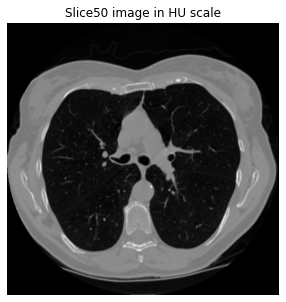

In [41]:
#Comparison of image after preprocessing 
#slice_show(preprocessed_inhale[0],50,'Slice50 preprocessed',False)
slice_show(HU_images_sitk_inhale[0],50,'Slice50 image in HU scale',False)

## Initial results: TRE between fixed and moving image

In [23]:
#Computation of baseline results 
TRE_baseline=[]
for patient in range(len(train_inhale_images)): # Accessing each patient
  patient_mean_tre_baseline, patient_std_tre_baseline= computeTRE_MeanStd(train_inhale_landmarks[patient], train_exhale_landmarks[patient], patient_voxel_size_list[patient])
  TRE_baseline.append([patient_mean_tre_baseline,patient_std_tre_baseline])
  print('For Patient {} The mean TRE is: {} and std of TRE is: {}'.format(patient+1, patient_mean_tre_baseline, patient_std_tre_baseline))

For Patient 1 The mean TRE is: 26.14727660137311 and std of TRE is: 11.337752042730125
For Patient 2 The mean TRE is: 21.640839694139274 and std of TRE is: 6.415267547626306
For Patient 3 The mean TRE is: 12.62588335216309 and std of TRE is: 6.381867428751379
For Patient 4 The mean TRE is: 29.583559738904107 and std of TRE is: 12.92417092574431


In [24]:
def output_landmarks(patient_directory):
  """
        Function to get the output landmarks from the specified file.
        
        Args: 
        patient_directory (str): directory of the output landmarks .txt file.

        Returns: 
        output_points (list): list containing the output landmarks. 

   """
  output_points=[]
  for files in sorted(os.listdir(patient_directory)):
    #Searching for the output points .txt file
    if 'outputpoints.txt' in files: 
      with open(os.path.join(patient_directory, files)) as f:
        lines_list= f.readlines()
        str_lines= [line.split(';') for line in lines_list]
        #Finding the column corresponding to the output index and converting it to list
        for i in range(len(str_lines)):
          start_index_output= str_lines[i][3].find('[')
          end_index_output= str_lines[i][3].find(']')
          out_pnts= str_lines[i][3][start_index_output+1:end_index_output].split()
          out_pnts_int= [int(x) for x in out_pnts]
          output_points.append(out_pnts_int)
  return output_points

In [25]:
def ImageRegistrationFramework(train_inhale_images_metadata, train_exhale_images_metadata,is_file,is_several,train,mask,masks_inhale, masks_exhale,parameter_map,experiment_number):

  """
        Function to perform image registration.
        
        Args: 
        train_inhale_images_metadata (sitk.Image): SimpleITK image corresponding to the inhale image.
        train_exhale_images_metadata (sitk.Image): SimpleITK image corresponding to the exhale image.
        is_file (bool): boolean variable used as flag. If true, registration parameter is a file. If false, default parameters are used.
        is_several (bool): boolean variable used as flag. If true, registration parameters is a group of parameters. If false, only one parameter is used.
        train (bool): boolean variable used as flag. If true, computation of TRE is done. 
        mask (bool): boolean variable used as flag. If true, masks are used for the registration. If false, masks are not used for the registration.
        mask_inhale (list): segmentation mask for the inhale image.
        mask_exhale (list): segmentation mask for the exhale image.
        parameter_map (str, list): registration parameter map. Str if only one parameter is used, list of strings if several parameters are used. 
        experiment_number (int): number of the experiment being done. 
        Returns: 
        TRE_population (list): list with the mean TRE and std of the TRE for each of the patients. 
        transformed_landmarks_population (list): list with the transformed landmarks after doing the transformation with the transformation parameters from the registration. 

  """


  TRE_population=[]
  transformed_landmarks_population=[]

  for i in range(len(train_exhale_images)):
    #Getting the fixed and moving image
    current_fixed_img= train_inhale_images_metadata[i]
    current_moving_img= train_exhale_images_metadata[i]
    current_output_directory= train_directory+'/'+str(i+1)+'/Experiment_'+str(experiment_number)
    #Creating the folder corresponding to the experiment being done 
    os.mkdir(current_output_directory)
    output_registered_image= current_output_directory+'/registered_image'+str(i+1)+'.nii.gz'
    elastixImageFilter = sitk.ElastixImageFilter()
    if mask== True:
      #Setting fixed and moving image, fixed and moving mask
      elastixImageFilter.SetFixedImage(current_fixed_img)
      elastixImageFilter.SetMovingImage(current_moving_img)
      mask_i= sitk.Cast(sitk.GetImageFromArray(np.moveaxis(masks_inhale[i],-1,0)), sitk.sitkUInt8)
      mask_e= sitk.Cast(sitk.GetImageFromArray(np.moveaxis(masks_exhale[i],-1,0)),sitk.sitkUInt8)
      mask_i.CopyInformation(current_fixed_img)
      mask_e.CopyInformation(current_moving_img)
      
      elastixImageFilter.SetFixedMask(mask_i)
      elastixImageFilter.SetMovingMask(mask_e)
    else: 
      #Setting fixed and moving image
      elastixImageFilter.SetFixedImage(current_fixed_img)
      elastixImageFilter.SetMovingImage(current_moving_img)

    if is_file== True:
      if is_several == True and parameter_map != None: 
        #Creation of parameter vector map
        parameterMapVector = sitk.VectorOfParameterMap()
        for p in parameter_map:
          parameterMapVector.append(sitk.ReadParameterFile(p))
        #Setting parameter map
        elastixImageFilter.SetParameterMap(parameterMapVector)
      elif is_several == False:
        #Setting parameter map
        elastixImageFilter.SetParameterMap(sitk.ReadParameterFile(parameter_map))
      else: 
        pass 
    elif is_file==False:
      if is_several == True and parameter_map != None:
        #Creation of default parameter vector map
        parameterMapVector = sitk.VectorOfParameterMap()
        for p in parameter_map:
          parameterMapVector.append(sitk.GetDefaultParameterMap(p))
        #Setting parameter map
        elastixImageFilter.SetParameterMap(parameterMapVector)
      elif is_several == False: 
        #Setting default parameter map
        elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap(parameter_map))
      else: 
        pass 
    else: 
      pass
    #Image registration
    elastixImageFilter.Execute()
    transformed_parameter_map= elastixImageFilter.GetTransformParameterMap()
    #Registered image is exported 
    sitk.WriteImage(elastixImageFilter.GetResultImage(),output_registered_image)
    # Transformation of landmarks with the deformation map obtained in the registration
    transformixImageFilter = sitk.TransformixImageFilter()

    # Set Moving image
    transformixImageFilter.SetMovingImage(current_moving_img)

    # Set the transformation parameter map
    transformixImageFilter.SetTransformParameterMap(transformed_parameter_map)

    # Set Points to be transformed 
    transformixImageFilter.SetFixedPointSetFileName(train_directory+'/'+str(i+1)+'/copd'+str(i+1)+'_300_iBH_xyz_r1.txt')
    transformixImageFilter.SetOutputDirectory(current_output_directory)
    transformixImageFilter.Execute()


    #Getting the transformed landmarks
    transformed_landmarks= output_landmarks(current_output_directory)
    transformed_landmarks_population.append(transformed_landmarks)
    
    #Calculating the TRE for the current experiment
    if train == True:
      patient_mean_tre, patient_std_tre = computeTRE_MeanStd(transformed_landmarks, train_exhale_landmarks[i], patient_voxel_size_list[i])
      print("For experiment {}, Patient #{}, the mean TRE is: {}, and the Std of the TRE is: {}".format(experiment_number,i+1,patient_mean_tre, patient_std_tre))
      TRE_patient= [patient_mean_tre, patient_std_tre]
      TRE_population.append(TRE_patient)
    else:
      pass 
    
  return TRE_population, transformed_landmarks_population

In [26]:
def ComputeTREChange(TRE_baseline, TRE_new):

    """
        Function to provide information of the 

        Args: 
        TRE_baseline (list): list corresponding to the baseline TRE for all patients.
        TRE_new (list): list corresponding to the new TRE obtained after performing the registration.

        Returns:
        TRE_change (list): list corresponding to the change in TRE (difference between the baseline and new TRE)  

    """
    TRE_change=[]
    for i in range(len(TRE_baseline)):
        # Computation of the difference between baseline and new TRE
        mean_difference= TRE_baseline[i][0] - TRE_new[i][0]
        std_difference=  TRE_baseline[i][1] - TRE_new[i][1]
        TRE_change.append([mean_difference,std_difference])
        percentage_mean= (np.abs(mean_difference)/TRE_baseline[i][0])*100
        percentage_std= (np.abs(std_difference)/TRE_baseline[i][1])*100
        #Printing of the results 
        if mean_difference > 0: 
            print("For Patient {}, the mean TRE (baseline-new) changed by a factor of {:.3f}, which means the metric is {:.3f} % better (lower mean TRE)".format(i+1, mean_difference, percentage_mean))
        elif mean_difference<0:
            print("For Patient {}, the mean TRE (baseline-new) changed by a factor of {:.3f}, which means the metric is {:.3f} % worse (higher mean TRE)".format(i+1, mean_difference, percentage_mean))
        else:
            print("For Patient {}, the mean TRE (baseline-new) did not change.".format(i+1))

        if std_difference >0:
            print("For Patient {}, the std of the TRE (baseline-new) changed by a factor of {:.3f}, which means the metric is {:.3f} % better (lower std of the TRE)".format(i+1, std_difference, percentage_std))
        elif std_difference<0:
            print("For Patient {}, the std of the TRE (baseline-new) changed by a factor of {:.3}, which means the metric is {:.3f} % worse (higher std of the TRE)".format(i+1, std_difference, percentage_std))
        else:
            print("For Patient {}, the std of the TRE (baseline-new) did not change.".format(i+1))
        print("------------------------------------------------------------------------------------------------------------------------------------------------")

    return TRE_change


## Experiments

***Experiment 1: Rigid registration of images without preprocessing***

In [ ]:
experiment_1,_= ImageRegistrationFramework(train_inhale_images_metadata, train_exhale_images_metadata,False,False,True,False,None,None,"rigid",1)

For experiment 1, Patient #1, the mean TRE is: 26.34475278093461, and the Std of the TRE is: 10.918807747609156
For experiment 1, Patient #2, the mean TRE is: 21.80171828413886, and the Std of the TRE is: 6.294840233670735
For experiment 1, Patient #3, the mean TRE is: 12.62588335216309, and the Std of the TRE is: 6.381867428751379
For experiment 1, Patient #4, the mean TRE is: 26.76952825314999, and the Std of the TRE is: 12.235068098719369


In [ ]:
TRE_change_e1= ComputeTREChange(TRE_baseline,experiment_1)

For Patient 1, the mean TRE (baseline-new) changed by a factor of -0.197, which means the metric is 0.755 % worse (higher mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 0.419, which means the metric is 3.695 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of -0.161, which means the metric is 0.743 % worse (higher mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 0.120, which means the metric is 1.877 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) did not change.
For Patient 3, the std of the TRE (baseline-new) did not change.
------------------------------------

***Experiment 2: Affine registration of images without preprocessing***

In [ ]:
experiment_2,_= ImageRegistrationFramework(train_inhale_images_metadata, train_exhale_images_metadata,False,False,True,False,None,None,"affine",2)

For experiment 2, Patient #1, the mean TRE is: 25.599154967308507, and the Std of the TRE is: 11.216229016215854
For experiment 2, Patient #2, the mean TRE is: 22.30286335741111, and the Std of the TRE is: 6.038188450938194
For experiment 2, Patient #3, the mean TRE is: 7.74791155191238, and the Std of the TRE is: 3.3788712011979696
For experiment 2, Patient #4, the mean TRE is: 26.0744902043448, and the Std of the TRE is: 10.167783838839037


In [ ]:
TRE_change_e2= ComputeTREChange(TRE_baseline,experiment_2)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 0.548, which means the metric is 2.096 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 0.122, which means the metric is 1.072 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of -0.662, which means the metric is 3.059 % worse (higher mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 0.377, which means the metric is 5.878 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 4.878, which means the metric is 38.635 % better (lower mean TRE)
For Patient 3, the std of the

***Experiment 3: Non-Rigid registration of images without preprocessing***

In [ ]:
experiment_3,_= ImageRegistrationFramework(train_inhale_images_metadata, train_exhale_images_metadata,False,True,True,False,None,None,["affine","bspline"],3)

For experiment 3, Patient #1, the mean TRE is: 23.29546549199486, and the Std of the TRE is: 11.176898780588198
For experiment 3, Patient #2, the mean TRE is: 19.73621273377082, and the Std of the TRE is: 6.403209269925713
For experiment 3, Patient #3, the mean TRE is: 5.5335311934683995, and the Std of the TRE is: 3.829985411532637
For experiment 3, Patient #4, the mean TRE is: 24.241282484815727, and the Std of the TRE is: 9.68054041974002


In [ ]:
TRE_change_e3= ComputeTREChange(TRE_baseline,experiment_3)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 2.852, which means the metric is 10.907 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 0.161, which means the metric is 1.419 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 1.905, which means the metric is 8.801 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 0.012, which means the metric is 0.188 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 7.092, which means the metric is 56.173 % better (lower mean TRE)
For Patient 3, the std of the

***Experiment 4: Translation - Affine - Bspline registration of images without preprocessing***

In [ ]:
experiment_4,_= ImageRegistrationFramework(train_inhale_images_metadata, train_exhale_images_metadata,None,None,True,None,None,None,None,4)

For experiment 4, Patient #1, the mean TRE is: 22.933809350653675, and the Std of the TRE is: 10.87447668154223
For experiment 4, Patient #2, the mean TRE is: 19.005691660740133, and the Std of the TRE is: 6.497829662227371
For experiment 4, Patient #3, the mean TRE is: 5.162804742926866, and the Std of the TRE is: 3.69660925140912
For experiment 4, Patient #4, the mean TRE is: 21.812840431178568, and the Std of the TRE is: 9.064928269090599


In [ ]:
TRE_change_e4= ComputeTREChange(TRE_baseline,experiment_4)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 3.213, which means the metric is 12.290 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 0.463, which means the metric is 4.086 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 2.635, which means the metric is 12.177 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of -0.0826, which means the metric is 1.287 % worse (higher std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 7.463, which means the metric is 59.109 % better (lower mean TRE)
For Patient 3, the std of 

***Experiment 5: Rigid registration of images with preprocessing***

In [ ]:
experiment_5,_= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,False,False,True,False,None,None,"rigid",5)

For experiment 5, Patient #1, the mean TRE is: 25.240213409015613, and the Std of the TRE is: 11.038718766881003
For experiment 5, Patient #2, the mean TRE is: 20.444695137829022, and the Std of the TRE is: 6.367366423931781
For experiment 5, Patient #3, the mean TRE is: 12.436362796720848, and the Std of the TRE is: 6.505858353833313
For experiment 5, Patient #4, the mean TRE is: 25.620649598114984, and the Std of the TRE is: 11.729913400714885


In [ ]:
TRE_change_e5= ComputeTREChange(TRE_baseline,experiment_5)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 0.907, which means the metric is 3.469 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 0.299, which means the metric is 2.638 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 1.196, which means the metric is 5.527 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 0.048, which means the metric is 0.747 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 0.190, which means the metric is 1.501 % better (lower mean TRE)
For Patient 3, the std of the T

***Experiment 6: Affine registration of images with preprocessing***

In [ ]:
experiment_6,_= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,False,False,True,False,None,None,"affine",6)

For experiment 6, Patient #1, the mean TRE is: 12.958503419636212, and the Std of the TRE is: 5.901608211755338
For experiment 6, Patient #2, the mean TRE is: 18.78132060696999, and the Std of the TRE is: 5.054536774080728
For experiment 6, Patient #3, the mean TRE is: 5.357932364403884, and the Std of the TRE is: 3.2573493831672353
For experiment 6, Patient #4, the mean TRE is: 20.009615526377402, and the Std of the TRE is: 6.1486187198588045


In [ ]:
TRE_change_e6= ComputeTREChange(TRE_baseline,experiment_6)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 13.189, which means the metric is 50.440 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 5.436, which means the metric is 47.947 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 2.860, which means the metric is 13.214 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 1.361, which means the metric is 21.211 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 7.268, which means the metric is 57.564 % better (lower mean TRE)
For Patient 3, the std of

***Experiment 7: Non-rigid registration of images with preprocessing***

In [ ]:
experiment_7,_= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,False,True,True,False,None,None,["affine","bspline"],7)

For experiment 7, Patient #1, the mean TRE is: 9.168537120592179, and the Std of the TRE is: 6.158983628612048
For experiment 7, Patient #2, the mean TRE is: 15.753418609914657, and the Std of the TRE is: 5.795905769451373
For experiment 7, Patient #3, the mean TRE is: 3.6243843305748102, and the Std of the TRE is: 3.128047091533606
For experiment 7, Patient #4, the mean TRE is: 15.838884746557202, and the Std of the TRE is: 4.822751577471746


In [ ]:
TRE_change_e7= ComputeTREChange(TRE_baseline,experiment_7)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 16.979, which means the metric is 64.935 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 5.179, which means the metric is 45.677 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 5.887, which means the metric is 27.205 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 0.619, which means the metric is 9.654 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 9.001, which means the metric is 71.294 % better (lower mean TRE)
For Patient 3, the std of 

***Experiment 8: Translation-Affine-Bspline registration of images with preprocessing***

In [ ]:
experiment_8,_= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,None,None,True,None,None,None,None,81)

For experiment 8, Patient #1, the mean TRE is: 7.925093534533562, and the Std of the TRE is: 6.268551916038443
For experiment 8, Patient #2, the mean TRE is: 14.851154206684829, and the Std of the TRE is: 5.82945692514785
For experiment 8, Patient #3, the mean TRE is: 3.4065448455980696, and the Std of the TRE is: 2.8526422724578
For experiment 8, Patient #4, the mean TRE is: 14.228954739901898, and the Std of the TRE is: 5.026735634218198


In [ ]:
TRE_change_e8= ComputeTREChange(TRE_baseline,experiment_8)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 18.222, which means the metric is 69.691 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 5.069, which means the metric is 44.711 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 6.790, which means the metric is 31.374 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 0.586, which means the metric is 9.132 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 9.219, which means the metric is 73.019 % better (lower mean TRE)
For Patient 3, the std of 

***Experiment 9: Parameters 54 + Image with preprocessing***

In [ ]:
experiment_9,_= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,True,False,True,False,None,None,"C:\\FP\\Par0054_sstvd.txt",9)

For experiment 9, Patient #1, the mean TRE is: 15.095118173027604, and the Std of the TRE is: 9.863288339828998
For experiment 9, Patient #2, the mean TRE is: 12.904263868355848, and the Std of the TRE is: 6.025574008675871
For experiment 9, Patient #3, the mean TRE is: 5.056719914684595, and the Std of the TRE is: 3.7544450572788195
For experiment 9, Patient #4, the mean TRE is: 18.42033701298861, and the Std of the TRE is: 8.20468808980319


In [ ]:
TRE_change_e9= ComputeTREChange(TRE_baseline,experiment_9)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 11.052, which means the metric is 42.269 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 1.474, which means the metric is 13.005 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 8.737, which means the metric is 40.371 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 0.390, which means the metric is 6.074 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 7.569, which means the metric is 59.950 % better (lower mean TRE)
For Patient 3, the std of 

***Experiment 10: Parameters 15 + Image with preprocessing***

In [ ]:
experiment_10,_= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,True,True,True,False,None,None,["C:\\FP\\Parameters.Par0015.expA.patient.NC.affine.txt","C:\\FP\\Parameters.Par0015.expA.patient.NC.bspline.txt"],101)

For experiment 10, Patient #1, the mean TRE is: 6.842275360690828, and the Std of the TRE is: 4.322588631908815
For experiment 10, Patient #2, the mean TRE is: 10.401896891366539, and the Std of the TRE is: 6.949360332231987
For experiment 10, Patient #3, the mean TRE is: 4.551643265941302, and the Std of the TRE is: 3.8437070647729934
For experiment 10, Patient #4, the mean TRE is: 7.3275958758307915, and the Std of the TRE is: 4.696298567766925


In [ ]:
TRE_change_e10= ComputeTREChange(TRE_baseline,experiment_10)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 19.305, which means the metric is 73.832 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 7.015, which means the metric is 61.874 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 11.239, which means the metric is 51.934 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of -0.534, which means the metric is 8.325 % worse (higher std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 8.074, which means the metric is 63.950 % better (lower mean TRE)
For Patient 3, the std o

## Segmentation of the lungs

In [23]:
def LungMarkers(input_image):

    """
        Function to generate useful lung markers for segmentation of the lungs 

        Inputs:
        input_image (np.ndarray): 3D numpy array corresponding to the input image from which to perform lung segmentation. 
        
        Returns:
        inner_lung_marker (np.ndarray): 3D numpy array containing the binary image that corresponds to the inner lung marker
        out_lung_marker (np.ndarray): 3D numpy array containing the binary image that corresponds to the external lung marker
        ws_marker (np.ndarray): 3D numpy array corresponding to the combination of inner and external lung markers to be used in
        the watershed algorithm. 

    """
    #Initial threshold of the image according to typical range of HU values for the lungs (-600)
    threshold_image= input_image< -600
    #Clearing borders (bone not corresponding to the lungs area)
    for slices in range(threshold_image.shape[2]):
        threshold_image[:,:,slices] = threshold_image[:,:,slices]
        threshold_image[:,:,slices] = clear_border(threshold_image[:,:,slices])
    #Getting image properties and ordering them by area
    lung_labels= measure.label(threshold_image)
    lung_regions_props = measure.regionprops(lung_labels)
    lung_regions_props.sort(key = lambda region: region.area)
    #Keeping largest area regions (corresponding to the lung)
    for region in lung_regions_props[:-1]:
        coordinates = tuple([tuple(k) for k in region.coords.transpose()])
        lung_labels[coordinates] = 0
    
    # Inner marker
    inner_lung_marker = lung_labels > 0
    
    #Generation of external markers 
    out_marker_in_layer= scipy.ndimage.binary_dilation(inner_lung_marker, iterations = 10)
    out_marker_out_layer= scipy.ndimage.binary_dilation(inner_lung_marker, iterations = 40 )
    out_lung_marker = out_marker_in_layer ^ out_marker_out_layer
    
    # Final marker for watershed algorithm 
    ws_marker = inner_lung_marker.astype(np.int16) * 2 + out_lung_marker.astype(np.int16) * 1
    
    
    return inner_lung_marker, out_lung_marker, ws_marker


In [24]:
image_test_segmentation = HU_images_sitk_inhale[0].copy()
inner_lung_marker, out_lung_marker,ws_marker = LungMarkers(image_test_segmentation)

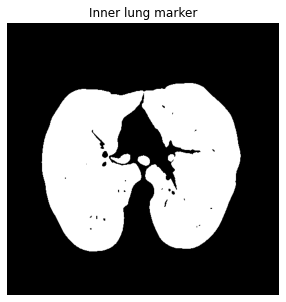

In [25]:
slice_show(inner_lung_marker,50,'Inner lung marker',False)

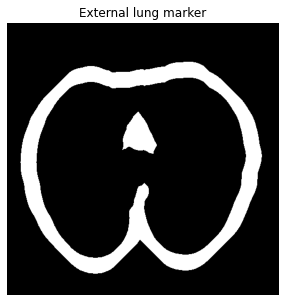

In [26]:
slice_show(out_lung_marker,50,'External lung marker',False)

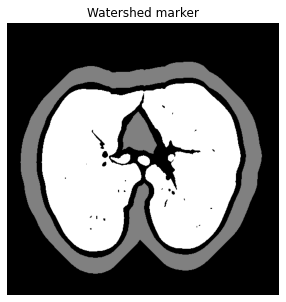

In [27]:
slice_show(ws_marker,50,'Watershed marker',False)

In [28]:
def LungSegmentation(img_slice,inner_lung_marker, ws_marker):
  """
        Function to generate the segmentation of the lungs

        Inputs:
        inner_lung_marker (np.ndarray): 3D numpy array corresponding to the inner lung marker
        ws_marker (np.ndarray): 3D numpy array corresponding to the watershed marker
        input_img (np.ndarray): 3D numpy array corresponding to the input image

        Returns:
        lung_borders(np.ndarray): 3D numpy array containing the borders detected in the image
        lung_segmentation (np.ndarray): 3D numpy array containing the final segmentation of the lung
        ws_lung (np.ndarray): 3D numpy array of the binary mask generated for the lung after applying watershed algorithm
        the watershed algorithm. 
        edges (np.ndarray): 3D numpy array corresponding to the edges detected in the image.
    """

    #Edges detection with sobel filter
  Ix= scipy.ndimage.sobel(img_slice, axis=0)
  Iy= scipy.ndimage.sobel(img_slice, axis=1)
  edges= np.hypot(Ix,Iy)
    
    # Watershed algorithm from the markers
  ws_lung = skimage.segmentation.watershed(edges, ws_marker)
    
    # Watershed result
  lung_borders = scipy.ndimage.morphological_gradient(ws_lung, size=(3,3)).astype(bool)
    
    # combine the lung and the regions near its border which may contain nodules
  lung_segmentation = np.bitwise_or(inner_lung_marker, lung_borders)
    # remove the small air pockets inside the lung
  lung_segmentation = scipy.ndimage.binary_fill_holes(lung_segmentation)
    
  return lung_borders, lung_segmentation, ws_lung,edges



In [32]:
lung_borders, lung_segmentation, ws_lung, edges = LungSegmentation(image_test_segmentation[:,:,50],inner_lung_marker[:,:,50],ws_marker[:,:,50])

Text(0.5, 1.0, 'Lung borders')

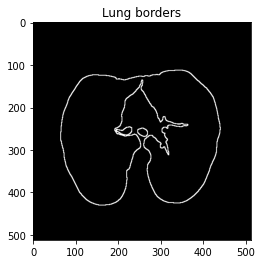

In [34]:
plt.imshow(lung_borders, cmap='gray')
plt.title('Lung borders')

Text(0.5, 1.0, 'Lung segmentation')

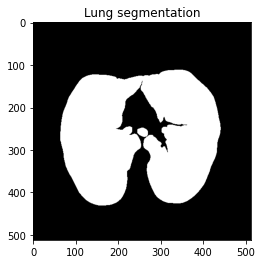

In [35]:
plt.imshow(lung_segmentation, cmap='gray')
plt.title('Final Lung segmentation')

Text(0.5, 1.0, 'Watershed Binary mask')

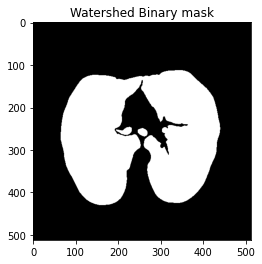

In [36]:
plt.imshow(ws_lung, cmap= 'gray')
plt.title('Watershed Binary mask')

Text(0.5, 1.0, 'Image Edges')

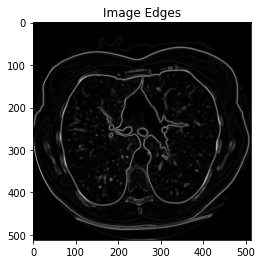

In [38]:
plt.imshow(edges, cmap= 'gray')
plt.title('Image Edges')

In [ ]:
#Creation of the inhale and exhale lung image masks 
masks_inhale=np.zeros(HU_images_sitk_inhale[0].shape)
masks_exhale=np.zeros(HU_images_sitk_exhale[0].shape)
for i in range(len(HU_images_sitk_inhale)):
    inner_lung_marker, out_lung_marker, ws_marker = LungMarkers(HU_images_sitk_inhale[i])
    inner_lung_marker2, out_lung_marker2, ws_marker2 = LungMarkers(HU_images_sitk_exhale[i])
    for k in range(HU_image_sitk_inhale.shape[2]):
      _,lung_segmentation_inhale,_,_= LungSegmentation(k,inner_lung_marker, ws_marker)
      _,lung_segmentation_exhale,_,_= LungSegmentation(k, inner_lung_marker2, ws_marker2)
      masks_inhale[k] = lung_segmentation_inhale 
      masks_exhale[k] = lung_segmentation_exhale 

In [ ]:
def output_transformed_landmarks(transformed_marks_directory, output_landmarks_vector):
  """
        Function to output a .txt file with the transformed lanmarks points indexes 

        Inputs:
        transformed_marks_directory (str): directory where the file will be saved
        output_landmarks_vector (list): list with the landmarks indexes 

        After the function is executed, the .txt file with the transformed lanmarks is generated.    
  """
  #Writing the .txt file with all the vectors of output points separating the points with a space. 
  with open(transformed_marks_directory, 'w') as f:
    for points in output_landmarks_vector:
      f.write(' '.join(map(str,points))+'\n')
    

# More experiments using segmentation masks

***Experiment 11: Registration parameters 15, images with preprocessing and using segmentation masks***

In [ ]:
experiment_11, output_landmarks_11= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,True,True,True,True,masks_inhale,masks_exhale,[parameters_directory+"/015/Parameters.Par0015.expA.patient.NC.affine.txt",parameters_directory+"/015/Parameters.Par0015.expA.patient.NC.bspline.txt"],11)

For experiment 11, Patient #1, the mean TRE is: 3.008675136626938, and the Std of the TRE is: 4.128387685602792
For experiment 11, Patient #2, the mean TRE is: 2.9700598000398495, and the Std of the TRE is: 3.7954034137181245
For experiment 11, Patient #3, the mean TRE is: 1.1981279504494118, and the Std of the TRE is: 0.9763184290221866
For experiment 11, Patient #4, the mean TRE is: 1.718008241713798, and the Std of the TRE is: 1.3475130715433843


In [ ]:
TRE_change_e11= ComputeTREChange(TRE_baseline,experiment_11)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 23.139, which means the metric is 88.493 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 7.209, which means the metric is 63.587 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 18.671, which means the metric is 86.276 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 2.620, which means the metric is 40.838 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 11.428, which means the metric is 90.511 % better (lower mean TRE)
For Patient 3, the std 

In [ ]:
print("The mean TRE of all patients of the population is", np.mean(np.array(experiment_11),axis=0)[0], "and the mean std is ", np.mean(np.array(experiment_11),axis=0)[1])

The mean TRE of all patients of the population is 2.2237177822074994 and the mean std is  2.5619056499716217


***Experiment 12: Registration parameters 35, images with preprocessing and using segmentation masks***

In [ ]:
experiment_12, output_landmarks_12= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,True,True,True,True,masks_inhale,masks_exhale,[parameters_directory+"/035/Par0035.SPREAD.MI.af.0.txt",parameters_directory+"/035/Par0035.SPREAD.MI.bs.1.ASGD.txt"],12)

For experiment 12, Patient #1, the mean TRE is: 1.7542132316407462, and the Std of the TRE is: 2.6089655693220415
For experiment 12, Patient #2, the mean TRE is: 4.181886844260821, and the Std of the TRE is: 5.035501467401524
For experiment 12, Patient #3, the mean TRE is: 1.1914126960100526, and the Std of the TRE is: 1.0503701147198163
For experiment 12, Patient #4, the mean TRE is: 4.846299778793719, and the Std of the TRE is: 8.44709987012146


In [ ]:
TRE_change_e12= ComputeTREChange(TRE_baseline,experiment_12)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 24.393, which means the metric is 93.291 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 8.729, which means the metric is 76.989 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 17.459, which means the metric is 80.676 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 1.380, which means the metric is 21.508 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 11.434, which means the metric is 90.564 % better (lower mean TRE)
For Patient 3, the std 

In [ ]:
print("The mean TRE of all patients of the population is", np.mean(np.array(experiment_12),axis=0)[0], "and the mean std is ", np.mean(np.array(experiment_12),axis=0)[1])

The mean TRE of all patients of the population is 2.993453137676335 and the mean std is  4.285484255391211


***Experiment 13: Registration parameters 35, images with preprocessing and using segmentation masks***

In [ ]:
experiment_13, output_landmarks_13= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,True,True,True,True,masks_inhale,masks_exhale,[parameters_directory+"/035/Par0035.SPREAD.MI.af.0.txt",parameters_directory+"/035/Par0035.SPREAD.MI.bs.1.ASGDPrime.txt"],13)

For experiment 13, Patient #1, the mean TRE is: 1.6874940954043633, and the Std of the TRE is: 2.425722656291951
For experiment 13, Patient #2, the mean TRE is: 4.215375048003838, and the Std of the TRE is: 5.07198138247978
For experiment 13, Patient #3, the mean TRE is: 1.1977222157356529, and the Std of the TRE is: 1.035037721671784
For experiment 13, Patient #4, the mean TRE is: 3.6623893718458764, and the Std of the TRE is: 7.152482316630945


In [ ]:
TRE_change_e13= ComputeTREChange(TRE_baseline,experiment_13)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 24.460, which means the metric is 93.546 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 8.912, which means the metric is 78.605 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 17.425, which means the metric is 80.521 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 1.343, which means the metric is 20.939 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 11.428, which means the metric is 90.514 % better (lower mean TRE)
For Patient 3, the std 

In [ ]:
print("The mean TRE of all patients of the population is", np.mean(np.array(experiment_13),axis=0)[0], "and the mean std is ", np.mean(np.array(experiment_13),axis=0)[1])

The mean TRE of all patients of the population is 2.690745182747433 and the mean std is  3.921306019268615


***Experiment 14: Registration parameters 15, images with preprocessing and using segmentation masks***

In [ ]:
experiment_14, output_landmarks_14= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,True,True,True,True,masks_inhale,masks_exhale,[parameters_directory+"/015/Parameters.Par0015.expA.patient.NC.affine.txt",parameters_directory+"/015/Parameters.Par0015.expA.patient.LNC.bspline.txt"],14)

For experiment 14, Patient #1, the mean TRE is: 2.1320044757382033, and the Std of the TRE is: 3.033288596646261
For experiment 14, Patient #2, the mean TRE is: 3.29270452972036, and the Std of the TRE is: 4.451112564826139
For experiment 14, Patient #3, the mean TRE is: 1.2072197024756601, and the Std of the TRE is: 0.9845576913830595
For experiment 14, Patient #4, the mean TRE is: 1.567720012871464, and the Std of the TRE is: 1.2001232444059555


In [ ]:
TRE_change_e14= ComputeTREChange(TRE_baseline,experiment_14)

For Patient 1, the mean TRE (baseline-new) changed by a factor of 24.015, which means the metric is 91.846 % better (lower mean TRE)
For Patient 1, the std of the TRE (baseline-new) changed by a factor of 8.304, which means the metric is 73.246 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 2, the mean TRE (baseline-new) changed by a factor of 18.348, which means the metric is 84.785 % better (lower mean TRE)
For Patient 2, the std of the TRE (baseline-new) changed by a factor of 1.964, which means the metric is 30.617 % better (lower std of the TRE)
------------------------------------------------------------------------------------------------------------------------------------------------
For Patient 3, the mean TRE (baseline-new) changed by a factor of 11.419, which means the metric is 90.439 % better (lower mean TRE)
For Patient 3, the std 

In [ ]:
print("The mean TRE of all patients of the population is", np.mean(np.array(experiment_14),axis=0)[0], "and the mean std is ", np.mean(np.array(experiment_14),axis=0)[1])

The mean TRE of all patients of the population is 2.0499121802014217 and the mean std is  2.417270524315354


In [ ]:
np.mean(np.array(experiment_14),axis=0)

array([2.04991218, 2.41727052])

***Experiment 15: Registration parameters 15 and 35 concatenated, images with preprocessing and using segmentation masks***

In [ ]:
experiment_15, output_landmarks_15= ImageRegistrationFramework(preprocessed_inhale_metadata, preprocessed_exhale_metadata,True,True,True,True,masks_inhale,masks_exhale,[parameters_directory+"/015/Parameters.Par0015.expA.patient.NC.affine.txt",parameters_directory+"/035/Par0035.SPREAD.MI.af.0.txt",parameters_directory+"/015/Parameters.Par0015.expA.patient.NC.bspline.txt",parameters_directory+"/015/Parameters.Par0015.expA.patient.LNC.bspline.txt",parameters_directory+"/035/Par0035.SPREAD.MI.bs.1.ASGDPrime.txt",],15)

For experiment 15, Patient #1, the mean TRE is: 2.5814535349883467, and the Std of the TRE is: 3.6667112250984313
For experiment 15, Patient #2, the mean TRE is: 2.6957470117880016, and the Std of the TRE is: 3.4726308568910405
For experiment 15, Patient #3, the mean TRE is: 1.1255316953014487, and the Std of the TRE is: 1.008676524751465
For experiment 15, Patient #4, the mean TRE is: 1.553629810648748, and the Std of the TRE is: 1.199966776702028


In [ ]:
print("The mean TRE of all patients of the population is", np.mean(np.array(experiment_15),axis=0)[0], "and the mean std is ", np.mean(np.array(experiment_15),axis=0)[1])

The mean TRE of all patients of the population is 1.9890905131816363 and the mean std is  2.336996345860741
